In [1]:
import sys
import os
import numpy as np
import tensorflow as tf
import pennylane as qml
import pandas as pd
from matplotlib import pyplot as plt

from quantum_neural_network import qnode_entangling, qnode_strong_entangling
from stat_functions import quantitative_analysis, get_mean_left_right_error_interval, verify_distribution_wilcoxtest
from experiments_main import carregar_tabela
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler



## Plot Functions

In [2]:
def plot_history(history, n_layers):
    plt.figure(figsize=(14,5), dpi=320, facecolor='w', edgecolor='k')
    plt.title(f"Loss for depth {n_layers}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(history.history['loss'], label="Loss/Epoch")
    plt.plot(history.history['val_loss'], label="Val Loss/Epoch")
    plt.xticks(range(0, len(history.history['loss'])+1, 5))
    plt.legend()
    plt.grid()
    plt.show()

In [3]:
def plot_prediction_versus_observed(n_layers, y_test, y_pred, mean_error_normal):
    for i in range(y_test.shape[1]):
        plt.figure(figsize=(20,5), dpi=320, facecolor='w', edgecolor='k')
        plt.title(f"Wind Speed Forecast for {i+1} hours ahead for {n_layers} layers")
        plt.xlabel("Samples")
        plt.ylabel("Wind Speed (m/s)")
        plt.plot(y_pred[:,i], label="Prediction", color='blue')
        plt.fill_between(range(y_pred.shape[0]), y_pred[:,i]-mean_error_normal[0,i], y_pred[:,i]+mean_error_normal[0,i], color='blue', alpha=0.05)
        plt.plot(y_test[:,i], label="Original", color='orange')
        plt.legend()
        plt.show()


## Importing Data

In [4]:
prev = 1
data_folder = "data"
city = "mucuri"
height = "150"

train_file = data_folder+"/"+city+"/"+height+"/"+"train"+height+"_"+city+".txt"
X_all,y_all = carregar_tabela(train_file, prev)

test_file = data_folder+"/"+city+"/"+height+"/"+"prev"+height+"_"+city+".txt"
X_test,y_test = carregar_tabela(test_file,prev)

n_features = X_all.shape[1]
n_instances = X_all.shape[0]
print(f"There are {n_features} features and {n_instances} instances in Train set")
print(f"There are {X_test.shape[1]} features and {X_test.shape[0]} instances in Test set")

There are 9 features and 548 instances in Train set
There are 9 features and 193 instances in Test set


In [5]:
X_all.head()

,0,1,2,3,4,5,6,7,8
0,30,11,2015,14,13.012139,75.105481,27.516129,72.930636,1020.422601
1,30,11,2015,15,12.726087,68.334332,27.238095,75.212121,1020.394348
2,30,11,2015,16,12.081111,64.457865,27.105263,75.741379,1020.508333
3,30,11,2015,17,11.647222,53.842100,26.305556,75.302632,1020.611000
4,30,11,2015,18,11.064444,53.945279,25.464286,76.592593,1020.866500


In [6]:
X_test.head()

,0,1,2,3,4,5,6,7,8
0,23,12,2015,12,12.242778,77.442821,21.516779,87.861111,1014.845833
1,23,12,2015,13,9.268333,73.171002,23.075269,73.338889,1014.793333
2,23,12,2015,14,8.734444,96.238878,22.545455,78.533333,1014.085333
3,23,12,2015,15,9.662222,110.156291,21.459770,83.722222,1013.541500
4,23,12,2015,16,8.620556,97.686662,22.133803,84.691275,1013.563333


## Scaling Data

In [7]:
scaler_x = MinMaxScaler(feature_range=(-1, 1))
#scaler_x = StandardScaler()
X_all_scaled = scaler_x.fit_transform(X_all)

X_test_scaled = scaler_x.transform(X_test)

In [8]:
print(X_all_scaled[0:5])

[[ 1.         -1.         -1.          0.2173913   0.90937393 -0.58515261
   0.44888689  0.02915543  0.92333644]
 [ 1.         -1.         -1.          0.30434783  0.86308842 -0.62328859
   0.39050308  0.117509    0.92268086]
 [ 1.         -1.         -1.          0.39130435  0.75872608 -0.64512135
   0.36260991  0.13800522  0.92532577]
 [ 1.         -1.         -1.          0.47826087  0.68851933 -0.70491071
   0.19468078  0.12101413  0.92770805]
 [ 1.         -1.         -1.          0.56521739  0.59422114 -0.70432959
   0.01802406  0.17096959  0.93363666]]


In [9]:
print(X_test_scaled[0:5])

[[ 0.51724138  1.         -1.          0.04347826  0.78488507 -0.57198841
  -0.81090577  0.607358    0.79393332]
 [ 0.51724138  1.         -1.          0.13043478  0.30359574 -0.59604785
  -0.48364124  0.04496558  0.79271511]
 [ 0.51724138  1.         -1.          0.2173913   0.21720817 -0.4661266
  -0.59489597  0.24612737  0.7762867 ]
 [ 0.51724138  1.         -1.          0.30434783  0.36733017 -0.38774195
  -0.82287686  0.44707401  0.76366762]
 [ 0.51724138  1.         -1.          0.39130435  0.19878002 -0.4579725
  -0.68133796  0.48460188  0.76417423]]


## Spliting Train, Validation and Test sets

In [10]:
train_ratio = 0.8
X_train, X_val, y_train, y_val = train_test_split(X_all_scaled, y_all, test_size=1 - train_ratio)

print("Len(Train):",len(X_train))
print("Len(Val):"  ,len(X_val))
print("Len(Test):" ,len(X_test_scaled))

Len(Train): 438
Len(Val): 110
Len(Test): 193


## Quantum Neural Network

In [11]:
n_qubits = n_features
n_layers = 2
print(f"Circuit size: {n_qubits} qubits")

Circuit size: 9 qubits


In [12]:
def create_quantum_model(n_layers, n_qubits, strong_entangling=False):
    print(f"Training with depth {n_layers}")
    weight_shapes = {"weights": (n_layers,n_qubits,3)}

    input_layer = tf.keras.layers.Input(shape=(n_qubits,))
    if strong_entangling:
        q_layer = qml.qnn.KerasLayer(qnode_strong_entangling, weight_shapes, output_dim=n_qubits)
    else:
        q_layer = qml.qnn.KerasLayer(qnode_entangling, weight_shapes, output_dim=n_qubits)
    activation=tf.keras.layers.Activation(tf.keras.activations.relu)
    output_layer = tf.keras.layers.Dense(prev,kernel_initializer='normal')

    optimizer = tf.keras.optimizers.Adamax(learning_rate=0.1)

    model = tf.keras.models.Sequential([input_layer, q_layer, activation, output_layer])
    model.compile(loss=['mse'], optimizer=optimizer, metrics=['mae'])

    return model


In [13]:
model = create_quantum_model(n_layers, n_qubits)
model.summary()

Training with depth 2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 9)                 54        
                                                                 
 activation (Activation)     (None, 9)                 0         
                                                                 
 dense (Dense)               (None, 1)                 10        
                                                                 
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________


In [14]:
es=EarlyStopping(monitor='val_loss', min_delta=0, patience=6, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
re=ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=0, mode='min', min_lr=0.00001)
history_model = model.fit(X_train, y_train
                        , epochs=50, batch_size=32
                        , verbose=1
                        , validation_data=(X_val, y_val))

Epoch 1/50
14/14 [==============================] - 2s 163ms/step - loss: 54.9229 - mae: 6.7927 - val_loss: 33.5968 - val_mae: 5.1550
Epoch 2/50
14/14 [==============================] - 2s 157ms/step - loss: 16.2913 - mae: 3.3891 - val_loss: 8.2128 - val_mae: 2.3712
Epoch 3/50
14/14 [==============================] - 2s 159ms/step - loss: 6.3221 - mae: 2.0449 - val_loss: 6.6534 - val_mae: 2.0799
Epoch 4/50
14/14 [==============================] - 2s 163ms/step - loss: 5.2247 - mae: 1.8492 - val_loss: 5.5657 - val_mae: 1.8910
Epoch 5/50
14/14 [==============================] - 2s 162ms/step - loss: 4.3833 - mae: 1.6806 - val_loss: 4.8169 - val_mae: 1.7404
Epoch 6/50
14/14 [==============================] - 2s 160ms/step - loss: 3.8394 - mae: 1.5442 - val_loss: 4.1293 - val_mae: 1.5951
Epoch 7/50
14/14 [==============================] - 2s 159ms/step - loss: 3.2114 - mae: 1.4086 - val_loss: 3.4068 - val_mae: 1.4438
Epoch 8/50
14/14 [==============================] - 2s 158ms/step - loss:

## Plotting Loss

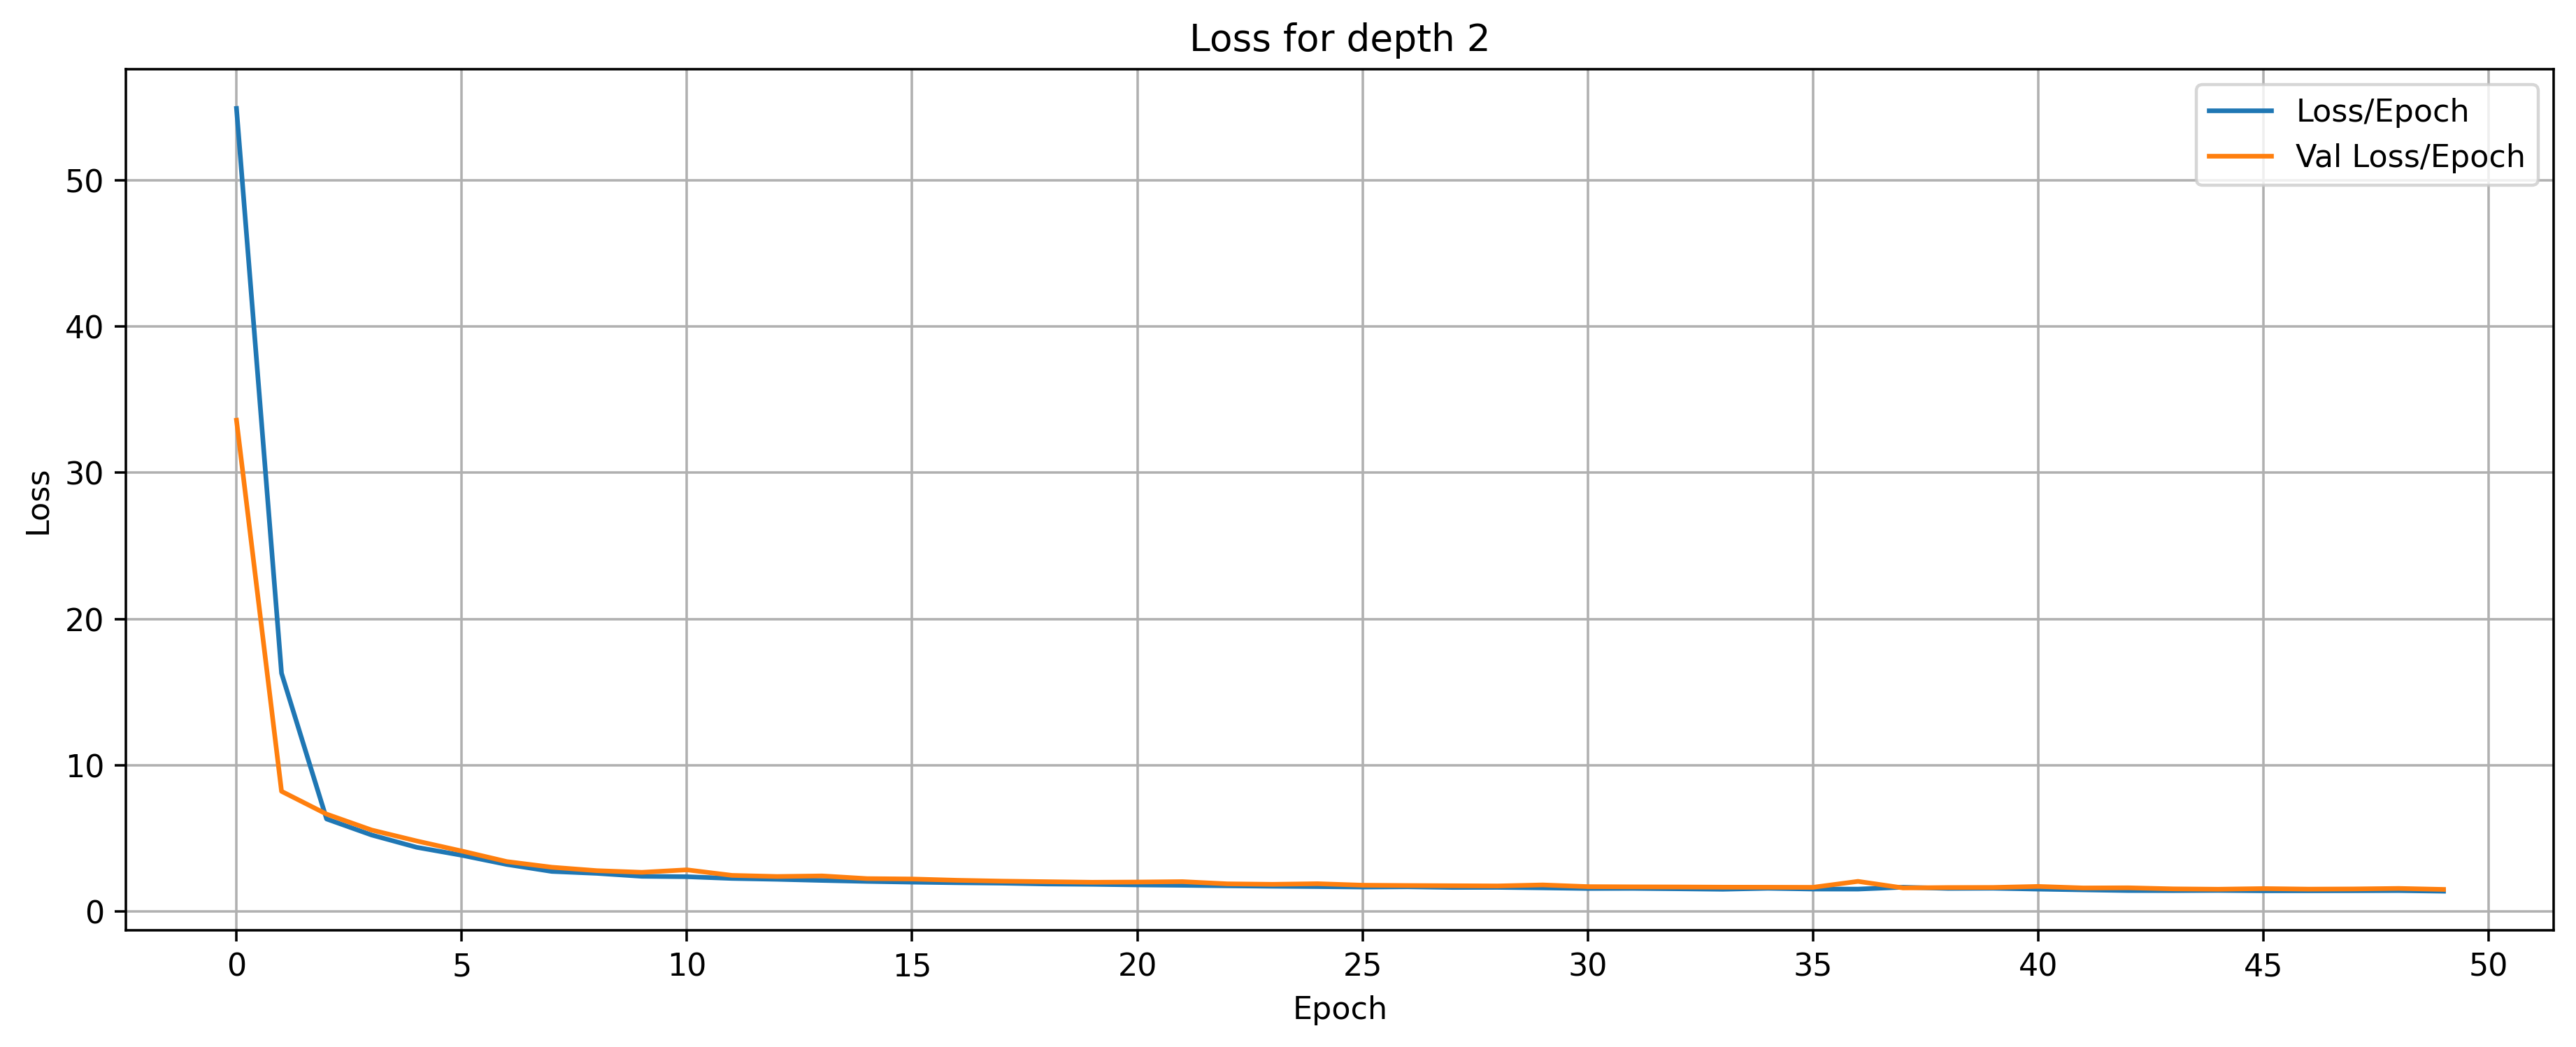

In [15]:
plot_history(history_model, n_layers)

## Prediction

7/7 [==============================] - 1s 88ms/step


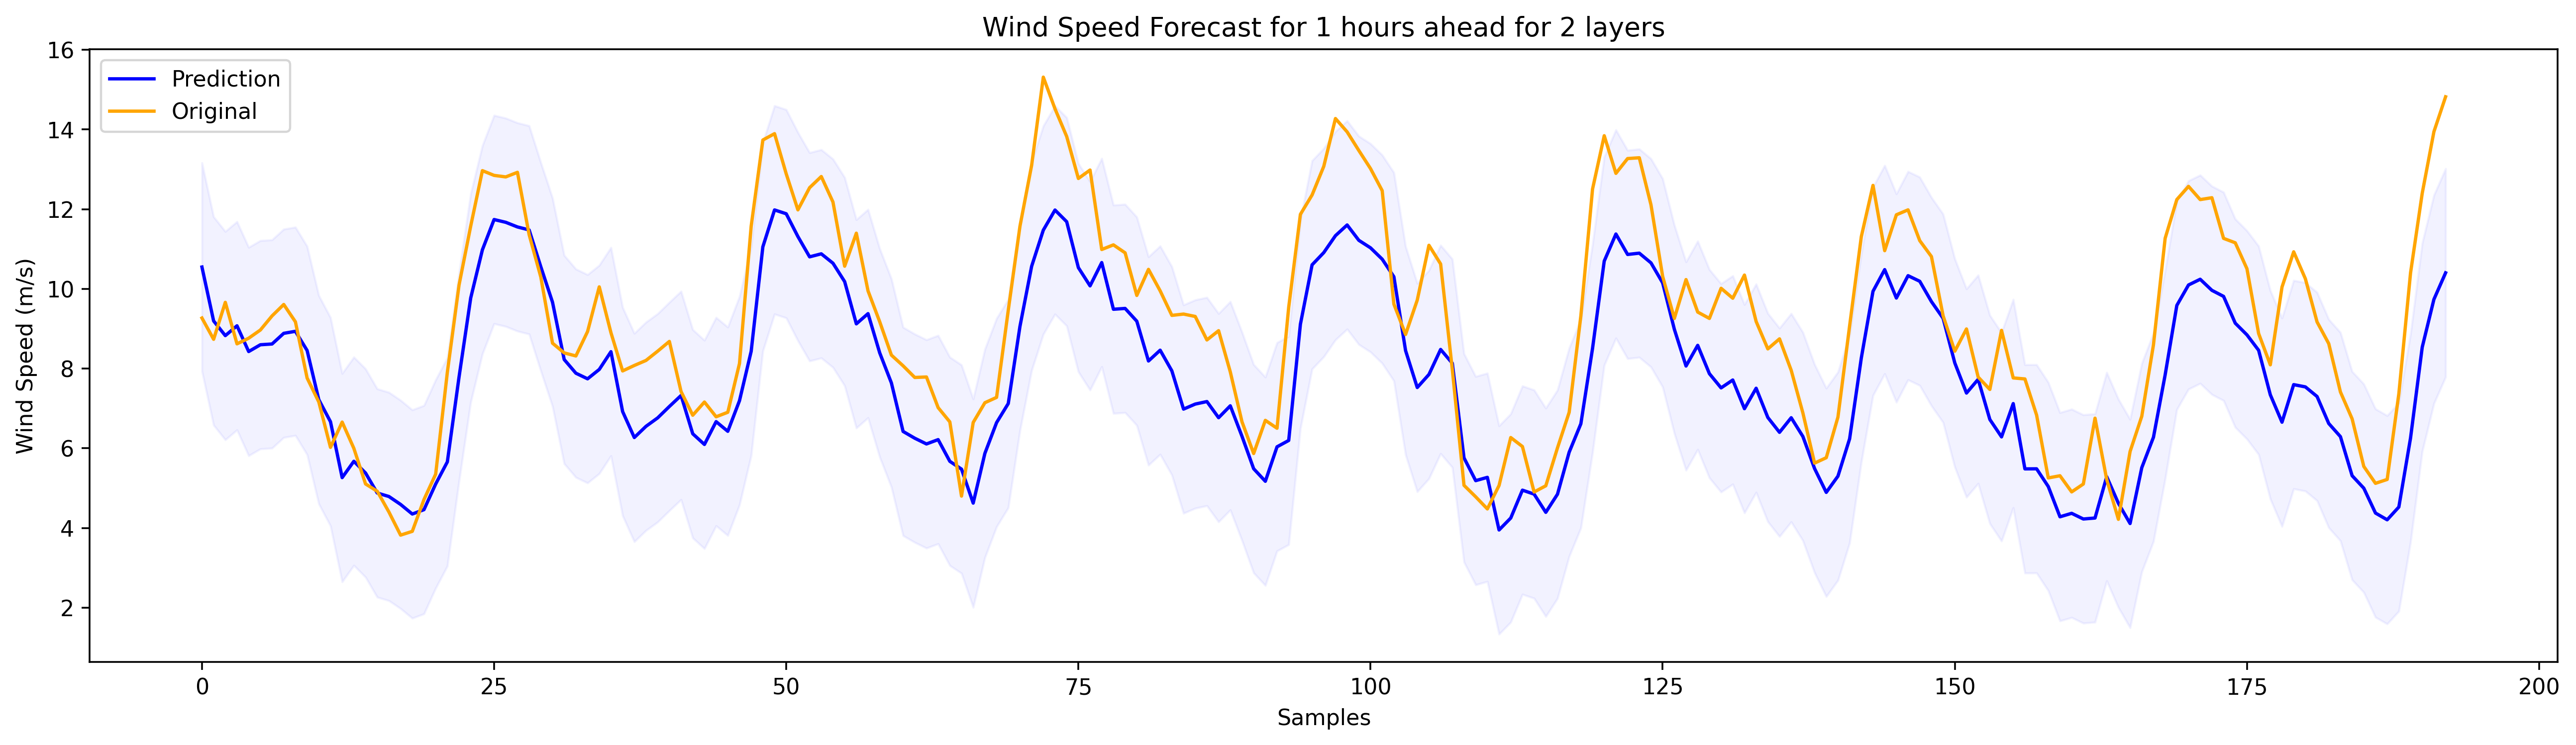

In [16]:
y_pred = model.predict(X_test_scaled,verbose=1)
mean_predictions, mean_error_normal, mean_error_left_normal, mean_error_right_normal = get_mean_left_right_error_interval(model, scaler_x, X_val, y_val, y_test, y_pred)
plot_prediction_versus_observed(n_layers, y_test, y_pred, mean_error_normal)


## Statistical Analysis

In [17]:
all_analysis = quantitative_analysis(y_test, [y_pred])
all_analysis

MAE: 1.4727947063271978
MSE: 3.1744549049574307
NMSE: 0.4340975098623814
RMSE: 1.7817000041975166
NRMSE: 0.6588607666740989
R: 0.9097539106304574
R²: 0.5636415656070854
Fator de 2: 1.0


,MAE,MSE,NMSE,RMSE,NRMSE,R,R²,Fator de 2
Index,,,,,,,,
1 depth,1.472795,3.174455,0.434098,1.7817,0.658861,0.909754,0.563642,1.0


In [18]:
verify_distribution_wilcoxtest(y_test[:,0],y_pred[:,0], 0.05)

Statistics=831.000, p=0.000
Different distribution (reject H0)


(831.0, 4.9157582155523835e-28)

## Creating model with strong entangling and searching for statistical difference

In [19]:
strong_model = create_quantum_model(n_layers, n_qubits, strong_entangling=True)
input_shape = (n_qubits,)
strong_model.build(input_shape)
strong_model.summary()

Training with depth 2
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 9)                 54        
                                                                 
 activation_1 (Activation)   (None, 9)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 10        
                                                                 
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________


In [20]:
strong_history_model = strong_model.fit(X_train, y_train
                        , epochs=50, batch_size=32
                        , verbose=1
                        , validation_data=(X_val, y_val))

Epoch 1/50
14/14 [==============================] - 2s 142ms/step - loss: 53.9831 - mae: 6.7781 - val_loss: 37.8913 - val_mae: 5.4902
Epoch 2/50
14/14 [==============================] - 2s 141ms/step - loss: 23.2007 - mae: 4.0533 - val_loss: 14.4120 - val_mae: 3.1169
Epoch 3/50
14/14 [==============================] - 2s 135ms/step - loss: 10.0914 - mae: 2.6130 - val_loss: 8.1393 - val_mae: 2.3552
Epoch 4/50
14/14 [==============================] - 2s 136ms/step - loss: 6.5989 - mae: 2.0579 - val_loss: 5.4678 - val_mae: 1.8925
Epoch 5/50
14/14 [==============================] - 2s 137ms/step - loss: 4.6992 - mae: 1.7128 - val_loss: 4.1640 - val_mae: 1.6377
Epoch 6/50
14/14 [==============================] - 2s 138ms/step - loss: 3.8696 - mae: 1.5412 - val_loss: 3.3995 - val_mae: 1.4703
Epoch 7/50
14/14 [==============================] - 2s 138ms/step - loss: 3.3036 - mae: 1.4243 - val_loss: 2.9383 - val_mae: 1.3692
Epoch 8/50
14/14 [==============================] - 2s 137ms/step - los

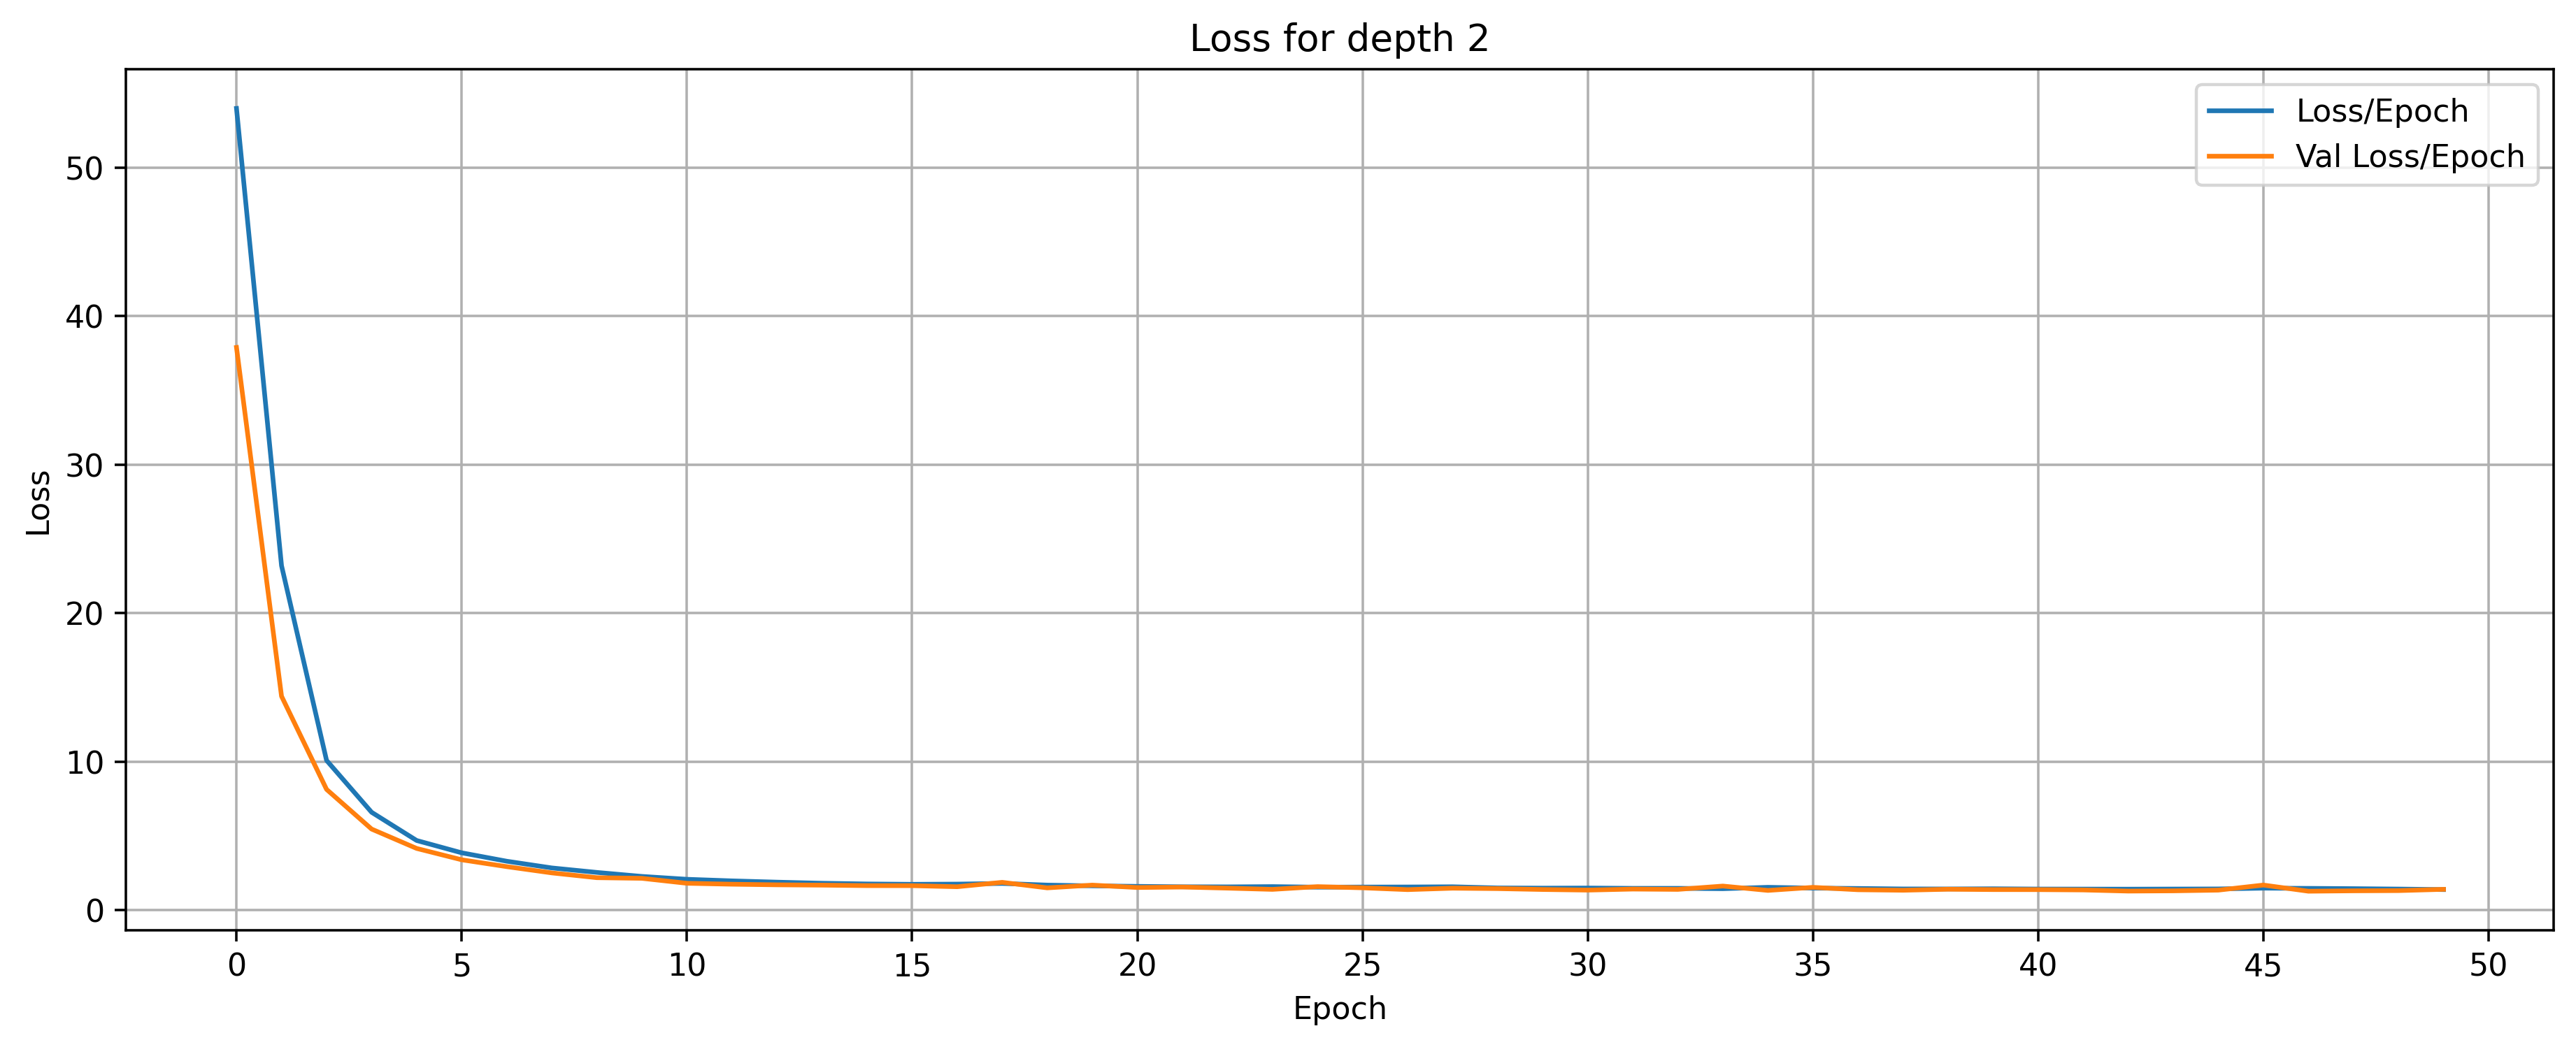

In [21]:
plot_history(strong_history_model, n_layers)

7/7 [==============================] - 0s 69ms/step


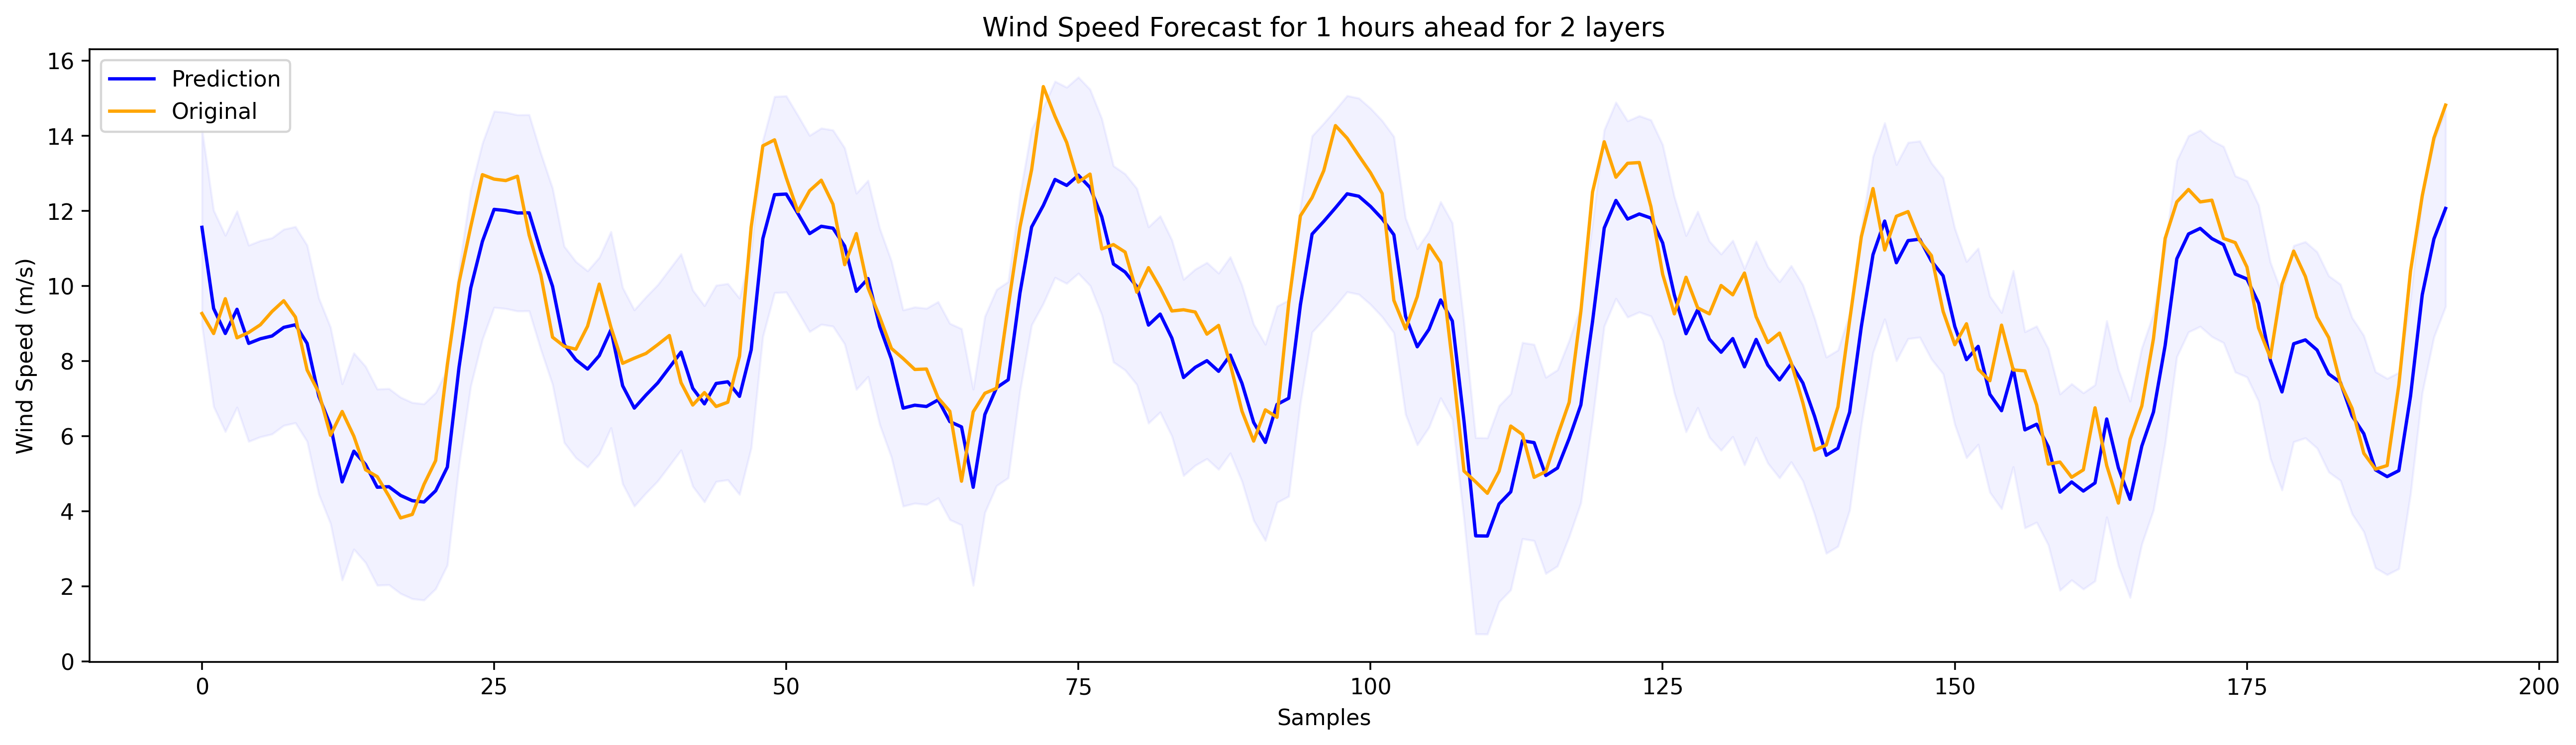

In [22]:
strong_y_pred = strong_model.predict(X_test_scaled,verbose=1)
mean_predictions, mean_error_normal, mean_error_left_normal, mean_error_right_normal = get_mean_left_right_error_interval(model, scaler_x, X_val, y_val, y_test, strong_y_pred)
plot_prediction_versus_observed(n_layers, y_test, strong_y_pred, mean_error_normal)


In [23]:
strong_analysis = quantitative_analysis(y_test, [strong_y_pred])
strong_analysis

MAE: 1.0513133244709087
MSE: 1.726502364417978
NMSE: 0.23609419557195077
RMSE: 1.3139643695389833
NRMSE: 0.4858952516458159
R: 0.9141403867886901
R²: 0.7626761471594453
Fator de 2: 1.0


,MAE,MSE,NMSE,RMSE,NRMSE,R,R²,Fator de 2
Index,,,,,,,,
1 depth,1.051313,1.726502,0.236094,1.313964,0.485895,0.91414,0.762676,1.0


In [24]:
verify_distribution_wilcoxtest(y_pred[:,0],strong_y_pred[:,0], 0.05)

Statistics=811.000, p=0.000
Different distribution (reject H0)


(811.0, 3.6960337401283284e-28)

## Creating deeper model and searching for statistical difference

In [25]:
n_layers = 6
model2 = create_quantum_model(n_layers, n_qubits, strong_entangling=False)
input_shape = (n_qubits,)
model2.build(input_shape)
model2.summary()

Training with depth 6
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 9)                 162       
                                                                 
 activation_2 (Activation)   (None, 9)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 10        
                                                                 
Total params: 172
Trainable params: 172
Non-trainable params: 0
_________________________________________________________________


In [26]:
history_model2 = model2.fit(X_train, y_train
                        , epochs=50, batch_size=32
                        , verbose=1
                        , validation_data=(X_val, y_val))

Epoch 1/50
14/14 [==============================] - 5s 324ms/step - loss: 48.7252 - mae: 6.3690 - val_loss: 25.0238 - val_mae: 4.3398
Epoch 2/50
14/14 [==============================] - 4s 318ms/step - loss: 11.6824 - mae: 2.7827 - val_loss: 7.1678 - val_mae: 2.0886
Epoch 3/50
14/14 [==============================] - 5s 326ms/step - loss: 4.8363 - mae: 1.7442 - val_loss: 5.2427 - val_mae: 1.7123
Epoch 4/50
14/14 [==============================] - 5s 335ms/step - loss: 3.6883 - mae: 1.4789 - val_loss: 4.6904 - val_mae: 1.6059
Epoch 5/50
14/14 [==============================] - 5s 330ms/step - loss: 3.1818 - mae: 1.3287 - val_loss: 4.0440 - val_mae: 1.4136
Epoch 6/50
14/14 [==============================] - 5s 327ms/step - loss: 2.8423 - mae: 1.2575 - val_loss: 3.5388 - val_mae: 1.3205
Epoch 7/50
14/14 [==============================] - 5s 329ms/step - loss: 2.5993 - mae: 1.2174 - val_loss: 3.1304 - val_mae: 1.2425
Epoch 8/50
14/14 [==============================] - 4s 319ms/step - loss:

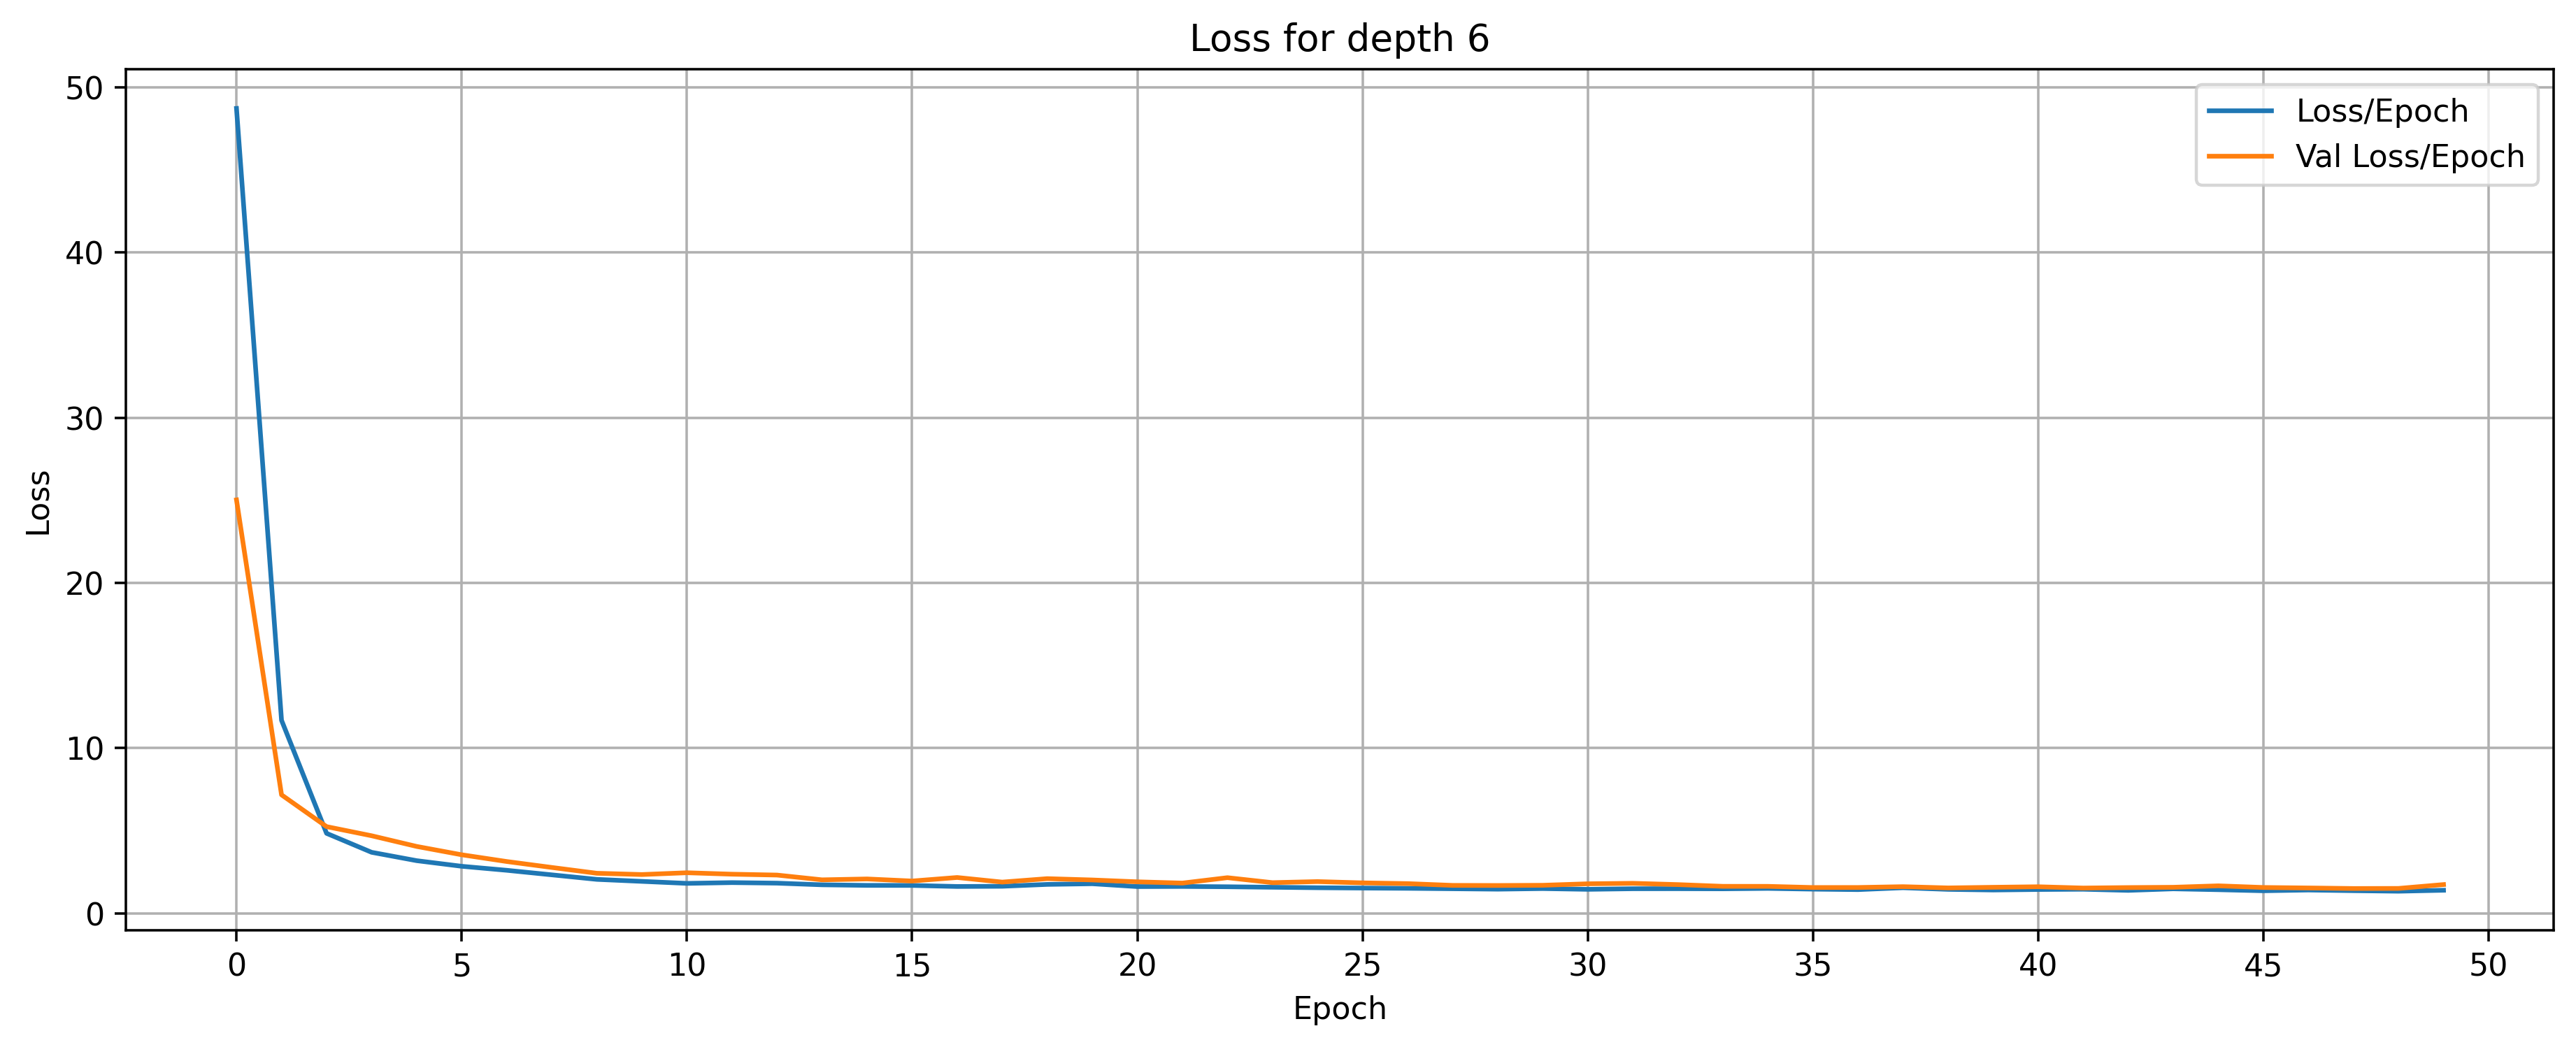

In [27]:
plot_history(history_model2, n_layers)

7/7 [==============================] - 1s 143ms/step


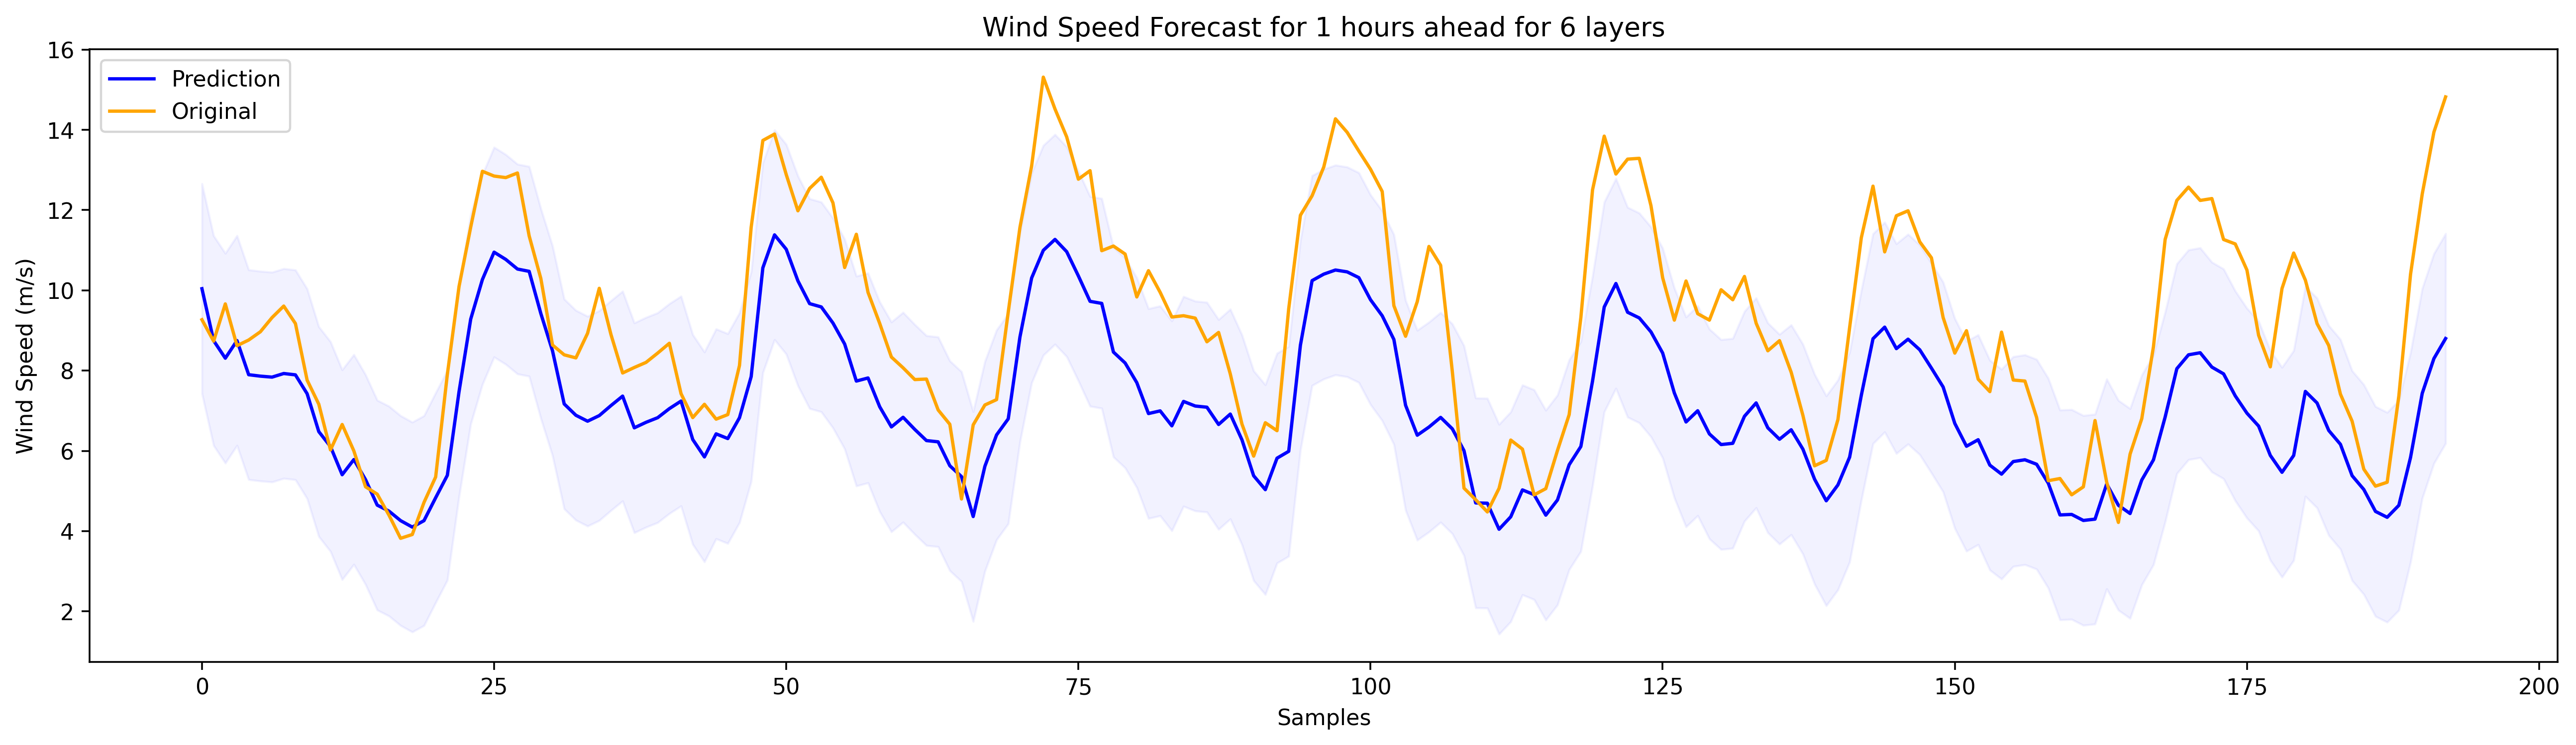

In [28]:
y_pred2 = model2.predict(X_test_scaled,verbose=1)
mean_predictions, mean_error_normal, mean_error_left_normal, mean_error_right_normal = get_mean_left_right_error_interval(model, scaler_x, X_val, y_val, y_test, y_pred2)
plot_prediction_versus_observed(n_layers, y_test, y_pred2, mean_error_normal)


In [29]:
all_analysis2 = quantitative_analysis(y_test, [y_pred2])
all_analysis2

MAE: 2.0757262615472243
MSE: 5.99813817939758
NMSE: 0.8202280156573476
RMSE: 2.4491096707574327
NRMSE: 0.9056644056477805
R: 0.8864016651287606
R²: 0.1754999634277703
Fator de 2: 1.0


,MAE,MSE,NMSE,RMSE,NRMSE,R,R²,Fator de 2
Index,,,,,,,,
1 depth,2.075726,5.998138,0.820228,2.44911,0.905664,0.886402,0.1755,1.0


In [30]:
verify_distribution_wilcoxtest(y_pred[:,0],y_pred2[:,0], 0.05)

Statistics=1132.000, p=0.000
Different distribution (reject H0)


(1132.0, 3.3199528391995644e-26)